# Lecture 18 (5/6/2022)

**Announcements**
- Pset 4 due by 11:59PM tonight
- This lecture: download the images from the github repo with lecture content

*Last time we covered:*
- Classification intro + $k$-nearest neighbors

**Today's agenda:**
- Evaluating classification


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluating classification algorithms


On Wednesday, we talked about the problems that classification algorithms solve and looked at an example solution: $k$-nearest neighbors applied to the `iris` dataset. 

Let's start with a slightly more complex version of this problem: predicting iris species using *sepal length* and *sepal width*.

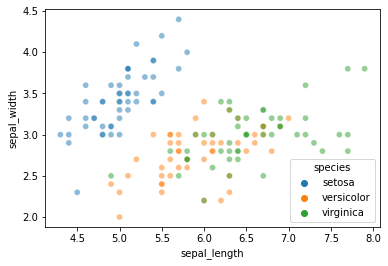

In [2]:
iris = sns.load_dataset('iris')
iris

sns.scatterplot(data = iris, x = "sepal_length", y = "sepal_width", hue = "species", alpha = 0.5)
plt.show()


As you can see, $k$-nearest neighbors is likely to struggle with this one a bit more than the petal length and petal width features we used on Wednesday.

*Let's see how it goes.*

First, we set aside training and test data, as before:

In [3]:
from sklearn.model_selection import train_test_split

x_vals = iris.loc[:, ('sepal_length', 'sepal_width')]
y_vals = iris.loc[:, 'species']

xtrain, xtest, ytrain, ytest = train_test_split(x_vals, y_vals, 
                                                test_size = 0.2, # we'll use a small test set here
                                                random_state = 0 # make this process reproducible
                                               )
xtrain = xtrain.reset_index(drop = True)
xtest = xtest.reset_index(drop = True)
ytrain = ytrain.reset_index(drop = True)
ytest = ytest.reset_index(drop = True)


Next, we fit our $k$-NN model:
- We'll use $k$ = 3

In [4]:
# Import the KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

# Initialize the classifier
knn = KNeighborsClassifier(n_neighbors = 3)

# Train the classifier
knn.fit(X = xtrain, y = ytrain)

KNeighborsClassifier(n_neighbors=3)

Now, we use the model to make predicions for our test data:

In [5]:
preds = knn.predict(X = xtest)
preds

array(['versicolor', 'versicolor', 'setosa', 'virginica', 'setosa',
       'virginica', 'setosa', 'virginica', 'virginica', 'versicolor',
       'versicolor', 'virginica', 'versicolor', 'virginica', 'virginica',
       'setosa', 'virginica', 'versicolor', 'setosa', 'setosa',
       'versicolor', 'versicolor', 'setosa', 'setosa', 'virginica',
       'setosa', 'setosa', 'virginica', 'versicolor', 'setosa'],
      dtype=object)

Let's compare these predictions to the true underlying labels for the test data:

In [6]:
knn_eval = pd.DataFrame({
    "sepal_length": xtest['sepal_length'],
    "sepal_width": xtest['sepal_width'],
    "species": ytest,
    "prediction": preds
})

knn_eval['correct'] = knn_eval['species'] == knn_eval['prediction']
knn_eval

,sepal_length,sepal_width,species,prediction,correct
0,5.8,2.8,virginica,versicolor,False
1,6.0,2.2,versicolor,versicolor,True
2,5.5,4.2,setosa,setosa,True
3,7.3,2.9,virginica,virginica,True
4,5.0,3.4,setosa,setosa,True
5,6.3,3.3,virginica,virginica,True
6,5.0,3.5,setosa,setosa,True
7,6.7,3.1,versicolor,virginica,False
8,6.8,2.8,versicolor,virginica,False
9,6.1,2.8,versicolor,versicolor,True


Let's graph the predictions for easier analysis:

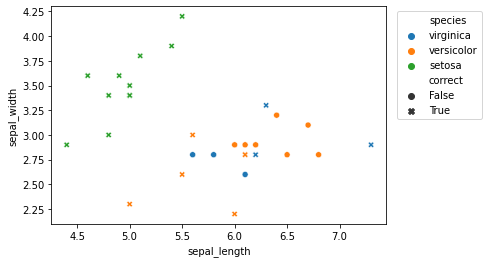

In [7]:
sns.scatterplot(data = knn_eval,
                x = "sepal_length",
                y = "sepal_width",
                hue = "species", # comment this out to just view overall accuracy
                style = "correct"
               )
plt.legend(loc = 'upper right', 
           bbox_to_anchor = (1.3, 1))
plt.show()

**How did our classifier perform?**

*What metric(s) should we use to evaluate it?*

- Percent that were correct (accuracy)


## Classifier evaluation metrics


There are a number of different ways to evaluate a classifier; the `sklearn` package exports many of the most common metrics [here](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics). As we'll see, some are better than others, so it's worth understanding the tradeoffs!


### Accuracy

Probably the most intuitive way to determine a classifier's success is just by looking at its overall accuracy. We can do that here with the `sklearn` `accuracy_score` function:

In [8]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true = knn_eval['species'], 
               y_pred = knn_eval['prediction'])


0.6666666666666666

Note: this is what the `score` function of the `KNeighborsClassifier` returns as well.

In [9]:
knn.score(X = xtest, y = ytest)

0.6666666666666666

**Problems with accuracy**

However, there are a few issues with simply using *accuracy* as our metric. 

Can you think of any?

- Some values much more common than others
- High stakes classification

1. *Imbalanced classification*: In many cases, the event or variable outcome we want to predict is *rare* in our training data. 
    - Ex. whether a credit card transaction is fraudulent (the vast majority are not)
    - In this case, our classifier could achieve very high accuracy by classifying *everything* it sees as non-fraudulent
    - So with imbalanced labels, accuracy isn't really telling us what we want to know about the classifier.

2. *Varying costs and benefits*: In other cases, independent of the probability of particular events, the *costs* of an error differ dramatically depending on the *type* of error.
    - Ex. a classifier for determining whether a medical image contains a tumor should *never* make the mistake of saying a tumor is non-cancerous when it's actually cancerous. If it sometimes says a tumor is cancerous and a follow-up reveals it's not, this is much less bad.
    - A regular *accuracy* metric treats all mistakes equally, but in these cases, we want our model evaluation to penalize some mistakes (incorrect negative labels) much more than others (incorrect positive labels).

*So what do we do?*

### Confusion matrix

Most of the more nuanced evaluation metrics rely on an underlying *[confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)* for the classifier. To unpack this more, we'll need to change our results above slightly.

Since most of the classifier's mistakes were around labeling the *versicolor* species, let's focus on that one. We'll change our results to be whether the classifier correctly identified each item as *versicolor* or *non-versicolor*, making this a **binary classification** problem. (note the best thing to do here would be to re-run the classifier as a binary classifier but in this case the results should be similar).

In [10]:
# Create a "mapping" that will change our prediction values to be BINARY predictions
binary_encoding = {
    'versicolor': 'versicolor',
    'virginica': 'non-versicolor',
    'setosa': 'non-versicolor'
}

# Add binary outcome and prediction columns encoding this information
knn_eval['binary_species'] = knn_eval['species'].map(binary_encoding)
knn_eval['binary_prediction'] = knn_eval['prediction'].map(binary_encoding)

# Take a look at these new columns to get a sense of our binary accuracy
knn_eval

,sepal_length,sepal_width,species,prediction,correct,binary_species,binary_prediction
0,5.8,2.8,virginica,versicolor,False,non-versicolor,versicolor
1,6.0,2.2,versicolor,versicolor,True,versicolor,versicolor
2,5.5,4.2,setosa,setosa,True,non-versicolor,non-versicolor
3,7.3,2.9,virginica,virginica,True,non-versicolor,non-versicolor
4,5.0,3.4,setosa,setosa,True,non-versicolor,non-versicolor
5,6.3,3.3,virginica,virginica,True,non-versicolor,non-versicolor
6,5.0,3.5,setosa,setosa,True,non-versicolor,non-versicolor
7,6.7,3.1,versicolor,virginica,False,versicolor,non-versicolor
8,6.8,2.8,versicolor,virginica,False,versicolor,non-versicolor
9,6.1,2.8,versicolor,versicolor,True,versicolor,versicolor


Now, let's use the `sklearn` `confusion_matrix` function to generate a confusion matrix for these binary results:

In [11]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(knn_eval['binary_species'], 
                       knn_eval['binary_prediction'], 
                       labels=['versicolor', 'non-versicolor']
                      )
mat

array([[ 6,  7],
       [ 3, 14]])

What's going on in this matrix?

Let's add some indexes and column names to clarify:

In [12]:
mat_df = pd.DataFrame(mat, 
                      index = ['species: versicolor', 'species: non-versicolor'],
                      columns = ['predicted: versicolor', 'predicted: non-versicolor']
                     )

mat_df

,predicted: versicolor,predicted: non-versicolor
species: versicolor,6,7
species: non-versicolor,3,14


*What's happening in this table?*

*Which values do we like and which ones do we dislike?*

predicted / species: non-versicolor: want high number

predicted / species: versicolor: want high number


Note: this allows us to distinguish between different *types* of errors, which in turn lets us move beyond just accuracy as a metric.

## Understanding the confusion matrix

The images below walk through how to label the different portions of the confusion matrix and the metrics we use based on it.

I'll send out the slides with these images so you can keep this with your lecture slides as well

**First, here's how we can understand the rows and columns in our confusion matrix:**

![confusion_matrix](img/confusion_matrix_1.png)

**Next, these are the *accurate* ("true") classification counts:**
- "True Positive" (TP): *true* classification with a *positive* label ("versicolor")
- "True Negative" (TN): *true* classification with a *negative* label ("non-versicolor")

![confusion_matrix](img/confusion_matrix_2.png)

**Finally, these are the *inaccurate* ("false") classification counts:**
- "False Positive" (FP): *false* classification with a *positive* label ("versicolor") -> Type I error
- "False Negative" (FN): *false* classification with a *negative* label ("non-versicolor") -> Type II error

![confusion_matrix](img/confusion_matrix_3.png)

## Evaluating the confusion matrix

Broadly, there are two kinds of metrics available with our confusion matrix: 
1. Metrics based on *subsets* of the confusion matrix (many)
2. Overall metrics that summarize the whole confusion matrix
    - Accuracy
    - Balanced accuracy
    - F1 score

We'll go through each one for our data above. 

The goal isn't to memorize these as we go, but to make sure you understand each one and what it tells us.

### Metrics for components of the confusion matrix

These break down into which *part* of the confusion matrix they are conditioning on: the *true values* or the *predicted values*. 

Let's walk through each one below:

#### Metrics conditioned on the *true* values ($y$)

**Conditioned on a *positive* true value**

True Postive Rate (TPR) = $\dfrac{TP}{TP + FN}$

Note: this is also called *sensitivity*, *hit rate*, *recall*, or *power*.

![confusion_matrix_tpr](img/confusion_matrix_tpr.png)

*What's our TPR for the data above?*

*What does this actually tell us?* *Do we want it to be large or small?*

When looking at "true" values, how often did you get it right?
-> Want a large value (close to 1)

In [13]:
# sklearn has a TPR "recall" function
from sklearn.metrics import recall_score

recall_score(y_true = knn_eval['binary_species'], 
             y_pred = knn_eval['binary_prediction'],
             labels = ['versicolor', 'non-versicolor'], # data labels
             pos_label = 'versicolor' # positive label
            )

# 6/13

0.46153846153846156

**Conditioned on a *positive* true value**

False Negative Rate (FNR) = $\dfrac{FN}{TP + FN}$

Note: this is also called *miss rate* or *Type II error rate*.

![confusion_matrix_fnr](img/confusion_matrix_fnr.png)

*What's our FNR for the data above?*

*What does this actually tell us?* *Do we want it to be large or small?*

**Conditioned on a *negative* true value**

False Positive Rate (FPR) = $\dfrac{FP}{FP + TN}$

Note: this is also called *false alarm rate* or *Type I error rate*.

![confusion_matrix_fpr](img/confusion_matrix_fpr.png)

*What's our FPR for the data above?*

*What does this actually tell us?* *Do we want it to be large or small?*

**Conditioned on a *negative* true value**

True Negative Rate (TNR) = $\dfrac{TN}{FP + TN}$

Note: this is also called *specificity* or *selectivity*, or *correct rejection rate*.

![confusion_matrix_tnr](img/confusion_matrix_tnr.png)

*What's our TNR for the data above?*

*What does this actually tell us?* *Do we want it to be large or small?*

#### Metrics conditioned on the *predicted* values ($\hat{y}$)

**Conditioned on a *positive* predicted value**

Positive predictive value (PPV) = $\dfrac{TP}{TP + FP}$

Note: this is also called *precision*.

![confusion_matrix_tpr](img/confusion_matrix_ppv.png)

*What's our PPV for the data above?*

*What does this actually tell us?* *Do we want it to be large or small?*

In [14]:
# sklearn also has a prectision function we can use directly
from sklearn.metrics import precision_score

precision_score(y_true = knn_eval['binary_species'], 
                y_pred = knn_eval['binary_prediction'],
                labels = ['versicolor', 'non-versicolor'], # data labels
                pos_label = 'versicolor' # positive label
               )

0.6666666666666666

**Conditioned on a *positive* predicted value**

False discovery rate (FDR) = $\dfrac{FP}{TP + FP}$

![confusion_matrix_fdr](img/confusion_matrix_fdr.png)

*What's our FDR for the data above?*

*What does this actually tell us?* *Do we want it to be large or small?*

**Conditioned on a *negative* predicted value**

Negative Predictive Value (NPV) = $\dfrac{TN}{FN + TN}$

![confusion_matrix_npv](img/confusion_matrix_npv.png)

*What's our NPV for the data above?*

*What does this actually tell us?* *Do we want it to be large or small?*

**Conditioned on a *negative* predicted value**

False Omission Rate (FOR) = $\dfrac{FN}{FN + TN}$

![confusion_matrix_for](img/confusion_matrix_for.png)

*What's our FOR for the data above?*

*What does this actually tell us?* *Do we want it to be large or small?*

### Metrics for summarizing the full confusion matrix

The metrics above demonstrated how we can quantify certain key aspects of our classifier's performance. 

But in many cases, we want to summarize how our classifier is performing overall with a metric applied to the confusion matrix as a whole. How can we do this?

Here are a few of the most common metrics:
1. Accuracy (okay for balanced problems)
2. *Balanced* accuracy
3. F1 score

We'll walk through each of these briefly to give a flavor for them.

#### Accuracy

We discussed this above already and it's fairly intuitive, but here's the formal breakdown: 

Accuracy = $\dfrac{TP + TN}{TP + FN + FP + TN}$

![confusion_matrix_for](img/confusion_matrix_acc.png)

In [15]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true = knn_eval['binary_species'], 
               y_pred = knn_eval['binary_prediction'])

0.6666666666666666

#### *Balanced* Accuracy

Balanced accuracy is the average of the true positive and true negative rates.

Balanced Accuracy = $\dfrac{TPR + TNR}{2}$

*How does this resolve the issues of imbalanced classification described above?*

In [16]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_true = knn_eval['binary_species'], 
                        y_pred = knn_eval['binary_prediction'])

0.6425339366515836

#### F1 Score

The F1 score is the *harmonic mean* (good for averaging *rates*) of TPR and PPV.
- Combines the rate at which our predictions of "versicolor" were correct across all "versicolor" predictions (PPV) and the rate at which true versicolors led us to predict "versicolor" (TPR).

F1 Score = $2 \times \dfrac{TPR \times PPV}{TPR + PPV}$



In [17]:
from sklearn.metrics import f1_score

f1_score(y_true = knn_eval['binary_species'], 
         y_pred = knn_eval['binary_prediction'],
         labels = ['versicolor', 'non-versicolor'], # labels to evaluate
         pos_label = 'versicolor' # name of positive label
        )

0.5454545454545455

## Advanced classifier evaluation: ROC curves

### Hard and Soft Classification

The $k$-nearest neighbors classifier chooses a predicted label $\hat{\lambda}$ for a new set of features $\theta$ by selecting the *mode* of the labels of the nearest training items. 

In this way, you can think of the nearest neighbors as essentially "voting" for the label of each test item. This produces a single label prediction for each test item. Put another way, all the predictions for our test items in the example above are either `'versicolor'` or `'non-versicolor'`. This sort of *decision policy* is referred to as **Hard Classification**. 

**But, it doesn't need to be this way.** We can also represent the "votes" of the nearest neighbors as generating a *probability distribution* over $\hat{\lambda}$ values. 
- For example, if there are 3 nearest neighbors for our new item and 2 are 'versicolor' and 1 is 'non-versicolor', there's a 2/3 chance that the new item should have a label of 'versicolor'. 
- Many of the classification algorithms we'll discuss can assign a *probability* of a particular label for a given test item rather than a strict label assignment.

This form of classification is called **Soft Classification**. 

The `sklearn` `KNeighborsClassifier` class exports a `predict_proba` function that is just like the `predict` function except instead of showing us the *hard predictions* for each test item, it shows us the *soft prediction* probabilities:

In [18]:
x_vals = iris.loc[:, ('sepal_length', 'sepal_width')]

iris['species_binary'] = iris['species'].map({'versicolor': 'versicolor',
                                             'virginica': 'non-versicolor',
                                             'setosa': 'non-versicolor'})
y_vals = iris.loc[:, 'species_binary']

xtrain, xtest, ytrain, ytest = train_test_split(x_vals, y_vals, 
                                                test_size = 0.2, # we'll use a small test set here
                                                random_state = 0 # make this process reproducible
                                               )
xtrain = xtrain.reset_index(drop = True)
xtest = xtest.reset_index(drop = True)
ytrain = ytrain.reset_index(drop = True)
ytest = ytest.reset_index(drop = True)


knn = KNeighborsClassifier(n_neighbors = 3)

# Train the classifier
knn.fit(X = xtrain, y = ytrain)

# Here's the original `predict` function
knn.predict(X = xtest)

# Here's the graded probability prediction
knn.predict_proba(X = xtest)

array([[0.        , 1.        ],
       [0.33333333, 0.66666667],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.66666667, 0.33333333],
       [1.        , 0.        ],
       [0.66666667, 0.33333333],
       [0.66666667, 0.33333333],
       [0.33333333, 0.66666667],
       [0.33333333, 0.66666667],
       [1.        , 0.        ],
       [0.33333333, 0.66666667],
       [1.        , 0.        ],
       [0.66666667, 0.33333333],
       [1.        , 0.        ],
       [0.66666667, 0.33333333],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.33333333, 0.66666667],
       [1.        , 0.        ]])

In the predictions above, the first column is the probability of 'non-versicolor' and the second is the probability of 'versicolor'.

This *Soft Classification* allows us to set more flexible decision policies about what kind of label $\hat{\lambda}$ we want to assign to a given test item. Using the *mode* of the nearest neighbor labels in k-NN classification sets a **classification threshold** of 50% (for binary classification), but we could choose any threshold we want depending on the problem.
- In some cases, we may want to predict a label value whenever *any* of the neighbors have that label (ex. risk of a fatal disease).
- Or, maybe we only want to predict a particular label if 90% of the neighbors have that label (ex. setting a high parole). 

However, the classification threshold we set will effect how often we assign a particular label to new pieces of data.

*Why does this matter?*

### Different thresholds change evaluation metrics

Critically, our choice of classification threshold will affect our evaluation metrics above in predictable ways.

In our `iris` dataset, labeling new data points based on the mode of 3 nearest neighbors sets a threshold of 2/3 for 'versicolor' labels. 

If we set a *lower* threshold of 1/3: 
- We will label *more* test items as 'versicolor' since we only need 1 out of 3 neighbors to be 'versicolor'
- We will have a **higher true positive rate** (and **lower false negative rate**) because we are more likely to detect all true versicolor items this way
- But, we will have a **higher false positive rate** (and **lower true negative rate**) since we will label more things as 'versicolor' that shouldn't be due to our low threshold.

If instead we set a very *high* threshold of 3/3:
- We will label *fewer* test items as 'versicolor' since we now need 3 out of 3 neighbors to be 'versicolor' before labeling a new item 'versicolor'.
- We will have a **lower true positive rate** (and **higher false negative rate**) because we are more likely to pass up on some true versicolor items this way
- We will have a **lower false positive rate** (and **higher true negative rate**) since we will label few things as 'versicolor' that shouldn't be due to our high threshold.


Let's illustrate this by looking at this pattern in our data.

### ROC curves: expressing accuracy across different thresholds

Below, we're going to compute the "versicolor probability" in our test set from above for a classifier with 5 nearest neighbors.

Then, we'll look at how different *thresholds* for identifying test items as 'versicolor' change our **true positive rate** and **false positive rate** in opposite directions.

**Step 1**: use the k-NN `predict_proba` function shown above to get probability values for each test item $p(\text{'versicolor'})$ rather than hard classifications

In [19]:
knn = KNeighborsClassifier(n_neighbors = 5).fit(X = xtrain, y = ytrain)

# Here's our soft classification with 5 nearest neighbors (converted to dataframe for easier processing)
versicolor_probs = pd.DataFrame(knn.predict_proba(X = xtest),
                                columns = ["non-versicolor_prob", "versicolor_prob"]
                               )

# Let's add the true values for comparison
versicolor_probs['true_label'] = ytest

versicolor_probs

,non-versicolor_prob,versicolor_prob,true_label
0,0.2,0.8,non-versicolor
1,0.4,0.6,versicolor
2,1.0,0.0,non-versicolor
3,1.0,0.0,non-versicolor
4,1.0,0.0,non-versicolor
5,0.8,0.2,non-versicolor
6,1.0,0.0,non-versicolor
7,0.6,0.4,versicolor
8,0.4,0.6,versicolor
9,0.6,0.4,versicolor


**Step 2**: Now, let's pick a range of *classification thresholds* for 'versicolor' and show how this changes what values we assign to the test items.

For $k$-nearest neighbors, the thresholds are intuitive because we can break them out by each possible voting arrangement of our 5 neighbors.

In [20]:
# Which test items get labeled 'versicolor' if you only need 1 nearest neighbor to be versicolor?
versicolor_probs['k1_label'] = np.where( # np.where is like an "if-else" condition for this column value
    versicolor_probs['versicolor_prob'] >= 0.2, # condition
    'versicolor', # value in all rows where condition above is True
    'non-versicolor' # value in all rows where condition above is False
)

# Which test items get labeled 'versicolor' if you need at least 2 nearest neighbors to be versicolor?
versicolor_probs['k2_label'] = np.where(
    versicolor_probs['versicolor_prob'] >= 0.4,
    'versicolor',
    'non-versicolor'
)

# Which test items get labeled 'versicolor' if you need at least 3 nearest neighbors to be versicolor?
versicolor_probs['k3_label'] = np.where(
    versicolor_probs['versicolor_prob'] >= 0.6,
    'versicolor',
    'non-versicolor'
)

# Which test items get labeled 'versicolor' if you need at least 4 nearest neighbors to be versicolor?
versicolor_probs['k4_label'] = np.where(
    versicolor_probs['versicolor_prob'] >= 0.8,
    'versicolor',
    'non-versicolor'
)

# Which test items get labeled 'versicolor' if you need *all 5* nearest neighbors to be versicolor?
versicolor_probs['k5_label'] = np.where(
    versicolor_probs['versicolor_prob'] >= 1.0,
    'versicolor',
    'non-versicolor'
)

versicolor_probs

,non-versicolor_prob,versicolor_prob,true_label,k1_label,k2_label,k3_label,k4_label,k5_label
0,0.2,0.8,non-versicolor,versicolor,versicolor,versicolor,versicolor,non-versicolor
1,0.4,0.6,versicolor,versicolor,versicolor,versicolor,non-versicolor,non-versicolor
2,1.0,0.0,non-versicolor,non-versicolor,non-versicolor,non-versicolor,non-versicolor,non-versicolor
3,1.0,0.0,non-versicolor,non-versicolor,non-versicolor,non-versicolor,non-versicolor,non-versicolor
4,1.0,0.0,non-versicolor,non-versicolor,non-versicolor,non-versicolor,non-versicolor,non-versicolor
5,0.8,0.2,non-versicolor,versicolor,non-versicolor,non-versicolor,non-versicolor,non-versicolor
6,1.0,0.0,non-versicolor,non-versicolor,non-versicolor,non-versicolor,non-versicolor,non-versicolor
7,0.6,0.4,versicolor,versicolor,versicolor,non-versicolor,non-versicolor,non-versicolor
8,0.4,0.6,versicolor,versicolor,versicolor,versicolor,non-versicolor,non-versicolor
9,0.6,0.4,versicolor,versicolor,versicolor,non-versicolor,non-versicolor,non-versicolor


**Step 3**: How do our **true positive rate** and **false positive rate** change for each of these thresholds?

In [21]:
# What's the TPR for our lowest threshold (k1) above?
k1_tpr = recall_score(y_true = versicolor_probs['true_label'], 
                      y_pred = versicolor_probs['k1_label'],
                      labels = ['versicolor', 'non-versicolor'],
                      pos_label = 'versicolor'
                     )
# What's the FPR for our lowest threshold (k1) above?
# Note FPR = 1 - TNR and TNR is just the recall (TPR) for the *negative* label, which we can set below
k1_fpr = 1 - recall_score(y_true = versicolor_probs['true_label'], 
                          y_pred = versicolor_probs['k1_label'],
                          labels = ['versicolor', 'non-versicolor'],
                          pos_label = 'non-versicolor' # positive label
                         )

# Same as above for k2 threshold
k2_tpr = recall_score(y_true = versicolor_probs['true_label'], 
                      y_pred = versicolor_probs['k2_label'],
                      labels = ['versicolor', 'non-versicolor'],
                      pos_label = 'versicolor'
                     )
k2_fpr = 1 - recall_score(y_true = versicolor_probs['true_label'], 
                          y_pred = versicolor_probs['k2_label'],
                          labels = ['versicolor', 'non-versicolor'],
                          pos_label = 'non-versicolor'
                         )

# Same as above for k3 threshold
k3_tpr = recall_score(y_true = versicolor_probs['true_label'], 
                      y_pred = versicolor_probs['k3_label'],
                      labels = ['versicolor', 'non-versicolor'],
                      pos_label = 'versicolor'
                     )
k3_fpr = 1 - recall_score(y_true = versicolor_probs['true_label'], 
                          y_pred = versicolor_probs['k3_label'],
                          labels = ['versicolor', 'non-versicolor'],
                          pos_label = 'non-versicolor'
                         )


# Same as above for k4 threshold
k4_tpr = recall_score(y_true = versicolor_probs['true_label'], 
                      y_pred = versicolor_probs['k4_label'],
                      labels = ['versicolor', 'non-versicolor'],
                      pos_label = 'versicolor'
                     )
k4_fpr = 1 - recall_score(y_true = versicolor_probs['true_label'], 
                          y_pred = versicolor_probs['k4_label'],
                          labels = ['versicolor', 'non-versicolor'],
                          pos_label = 'non-versicolor'
                         )

# Same as above for k5 threshold
k5_tpr = recall_score(y_true = versicolor_probs['true_label'], 
                      y_pred = versicolor_probs['k5_label'],
                      labels = ['versicolor', 'non-versicolor'],
                      pos_label = 'versicolor'
                     )
k5_fpr = 1 - recall_score(y_true = versicolor_probs['true_label'], 
                          y_pred = versicolor_probs['k5_label'],
                          labels = ['versicolor', 'non-versicolor'],
                          pos_label = 'non-versicolor'
                         )

Phew! Now let's combine the above to see how they compare:

In [22]:
# For each of our thresholds, what is the true positive rate and the false positive rate?

np.arange(0, 1.1, 0.2)
roc_df = pd.DataFrame({
    "threshold": np.arange(0.2, 1.1, 0.2),
    "TPR": [k1_tpr, k2_tpr, k3_tpr, k4_tpr, k5_tpr],
    "FPR": [k1_fpr, k2_fpr, k3_fpr, k4_fpr, k5_fpr]
})

roc_df

,threshold,TPR,FPR
0,0.2,1.000000,0.235294
1,0.4,0.923077,0.176471
2,0.6,0.384615,0.117647
3,0.8,0.230769,0.117647
4,1.0,0.153846,0.058824


Now, our final step is to graph this relationship. 

This is called an **ROC curve** (Receiver Operating Characteristic) and we'll see why it's useful once we've plotted it.

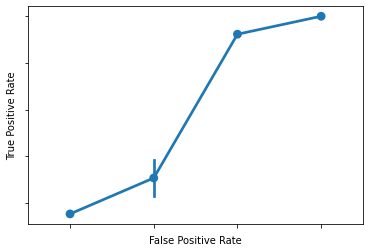

In [23]:
# ROC curve by hand

g= sns.pointplot(
    data = roc_df,
    x = "FPR",
    y = "TPR"
)

g.set_xlabel("False Positive Rate")
g.set_ylabel("True Positive Rate")
g.set_xticklabels([])
g.set_yticklabels([])
plt.show()

*What is that??*

Answer: a somewhat clumsy ROC curve (since we're not working with much data here).

*What does this mean?*

- Each of our points above is the TPR and FPR for a given *classification threshold*
- When we set a *low threshold*, we expect TPR and FPR to be very high (top right)
- When we set a *high threshold*, we expect TPR and FPR to both be very low (bottom left)

What about in between?

- For every threshold in between the top right (low) and bottom left (high), we want to *keep TPR high while FPR goes down*. 
- Put another way, we want to reduce FPR without having to also sacrifice TPR. 

Given the above, **a good ROC curve is one that swings as close to the *top left* portion of the axes as possible**.

Here's a picture that illustrates this:

![roc](img/roc.png)

([source](https://medium.com/the-owl/evaluation-metrics-part-3-47c315e07222))


**Compared to what?**

Note the dashed line across the middle. This indicates what you would expect to happen with TPR and FPR if your classifier was *random*. In other words, we can compare our ROC curve to the "random classifier" line to determine how much better our classifier is doing than random guessing. 

We use a metric called *area under the curve (AUC)* to calculate this difference.

This measures the area under the ROC curve. The value ranges from 0 to 1, but since a random classifier has an AUC of 0.5, we're looking for values > 0.5.


## ROC curves in scikit-learn

Fortunately, we don't need to do all the manual calculations above to generate an ROC curve.

As usual, `scikit-learn` has us covered!

Below, we call the `roc_curve` function to generate an ROC curve:

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(
    y_true = ytest,
    y_score = knn.predict_proba(X = xtest)[:, 1],
    pos_label = 'versicolor'
)


tpr
fpr
thresholds

array([2. , 1. , 0.8, 0.6, 0.4, 0.2, 0. ])

Then, we can graph the results in seaborn:

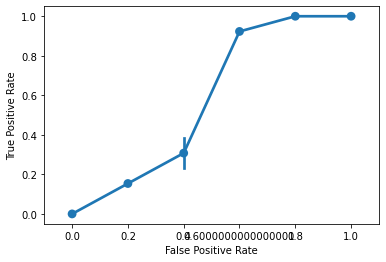

In [25]:
g = sns.pointplot(
    x = fpr,
    y = tpr
)

g.set_xlabel("False Positive Rate")
g.set_ylabel("True Positive Rate")
g.set_xticklabels(np.arange(0, 1.1, 0.2))
plt.show()

### AUC

`scikit-learn` also exports an AUC function that will report how our ROC curve fares:

In [26]:
from sklearn.metrics import roc_auc_score


roc_auc_score(
    y_true = ytest,
    y_score = knn.predict_proba(X = xtest)[:, 1],
    labels = ['versicolor', 'non-versicolor']
)

0.8755656108597285

# Evaluating classification algorithms: summary


When we use a classification algorithm like $k$-nearest neighbors, we want a way to quantify *how well it performs* with test data.

1. The most intuitive way to do so is with accuracy, but this can mis-construe our classifier's performance when we have imbalanced data.

2. Alternatives that rely on the *confusion matrix* allow us to weight the relative impact of different kinds of *errors* (false positives and false negatives).

3. Recognizing that our rate of false positives and false negatives is sensitive to the *classification threshold* used in our model (e.g., the "voting" procedure in k-NN), we can use an ROC curve to examine the classifier's success across a range of thresholds.

